# Melanoma Detection

## Goal
The goal of this project is to develop a convolutional neural network (CNN)-based model capable of accurately detecting melanoma, a deadly form of skin cancer responsible for 75% of skin cancer-related fatalities if not diagnosed early. Early detection is critical, and an automated system that analyzes skin images and alerts dermatologists to potential melanoma cases could significantly reduce the time and effort needed for diagnosis. By leveraging machine learning, this solution aims to provide a more efficient and reliable approach to skin cancer detection.

## Description
To achieve this, the project aims to build a multiclass classification model using a custom CNN framework developed with TensorFlow. The dataset used for training consists of 2,357 images of various skin conditions, both malignant and benign, sourced from the International Skin Imaging Collaboration (ISIC). These images are organized according to ISIC classifications, with most conditions being equally represented, although melanomas and moles are slightly more frequent. The dataset includes a range of conditions, such as the ones listed below :

Actinic keratosis, Basal cell carcinoma, Dermatofibroma, Melanoma, Nevus, Pigmented benign keratosis, Seborrheic keratosis, Squamous cell carcinoma, and Vascular lesions.

In [55]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Data Reading

In [8]:
#import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pathlib
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, datasets, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img

import random
import PIL

# Dataset creation

In [56]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [10]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [11]:
batch_size = 32
img_height = 180
img_width = 180
epochs = 20

Use 80% of the images for training, and 20% for validation.

In [19]:
def createDataSetFromPath(path):
  dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path, batch_size=32,
    image_size=(180,180), label_mode='categorical',
    seed=123,subset="training",
    validation_split=0.2
    )
  class_names = dataset.class_names
  dataset = dataset.unbatch().batch(32)

  return dataset, class_names

In [20]:
train_ds, class_names = createDataSetFromPath(data_dir_train)

# Check the type
print(type(train_ds))

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [21]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

# Dataset visualisation

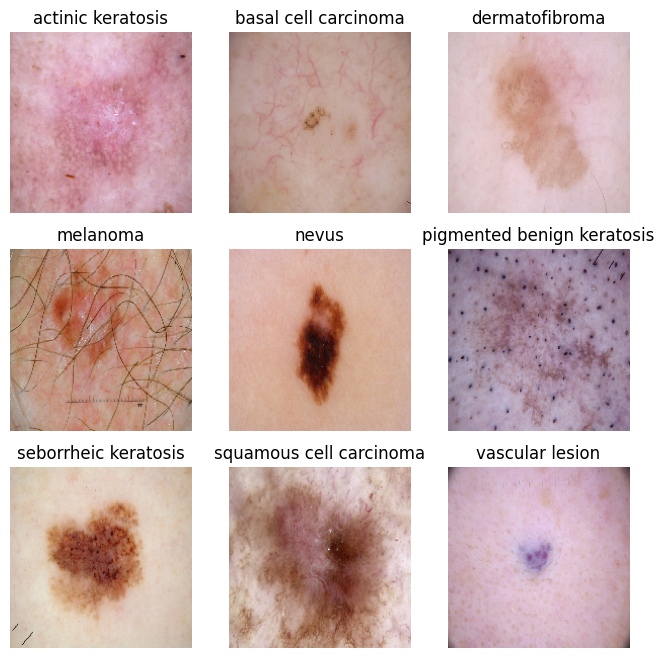

In [22]:
# Visualize some samples of the data set

# Dictionary to store the path of image as per the class
files_path = {}

for c in class_names:
    files_path[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

# Visualize image
plt.figure(figsize=(8,8))
index = 0
for c in class_names:
    path_list = files_path[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [24]:
# Find distribution of the classes to check if its evenly distributed
def count_of_classes(pathDir):
    count = []
    for path in pathlib.Path(pathDir).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]))
    subD = [name for name in os.listdir(pathDir) if os.path.isdir(os.path.join(pathDir, name))]
    return pd.DataFrame(list(zip(subD,count)),columns =['Class Title', 'No. of Items'])
classDist_dataframe = count_of_classes(data_dir_train)
classDist_dataframe

,Class Title,No. of Items
0,melanoma,438
1,dermatofibroma,95
2,seborrheic keratosis,77
3,vascular lesion,139
4,squamous cell carcinoma,181
5,actinic keratosis,114
6,basal cell carcinoma,376
7,nevus,357
8,pigmented benign keratosis,462


There is a class imbalance in the dataset, which can be addressed using the Python package Augmentor to generate additional samples for all classes, ensuring that no class has too few samples.

# Data augmentation

In [11]:
#install Augmentor
!pip install Augmentor

In [28]:
import Augmentor
for aClassName in class_names:
    path = "/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/" + aClassName
    p = Augmentor.Pipeline(path)
    p.output_directory = path + "_output"
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78C37977A530>: 100%|██████████| 500/500 [00:27<00:00, 17.86 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78C370262B00>: 100%|██████████| 500/500 [00:28<00:00, 17.79 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78C378D0B190>: 100%|██████████| 500/500 [00:26<00:00, 18.90 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x78C370595C30>: 100%|██████████| 500/500 [01:43<00:00,  4.85 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x78C3707A1D20>: 100%|██████████| 500/500 [01:36<00:00,  5.19 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78C378403BB0>: 100%|██████████| 500/500 [00:29<00:00, 16.85 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78C3781BA8F0>: 100%|██████████| 500/500 [00:53<00:00,  9.31 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78C37A855900>: 100%|██████████| 500/500 [00:27<00:00, 18.10 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78C37050ED70>: 100%|██████████| 500/500 [00:30<00:00, 16.50 Samples/s]


In [29]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


# Model Building & training

In [30]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size=32,
    image_size=(180,180), label_mode='categorical',
    seed=123,subset="training",
    validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [63]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,batch_size=32,
    image_size=(180,180), label_mode='categorical',
    seed=123,subset="validation",
    validation_split=0.2)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [64]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [65]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
model = models.Sequential()

model.add(layers.Rescaling(1./255, input_shape=(180, 180, 3)))

# First convolutional layer with 32 filters and 3x3 kernel
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Second convolutional layer with 64 filters and 3x3 kernel
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Third convolutional layer with 128 filters and 3x3 kernel
model.add(Conv2D(128, (3, 3), activation='relu'))

# Flatten the output for the fully connected layer
model.add(layers.Flatten())

# Fully connected layer with 64 neurons
model.add(layers.Dense(64, activation='relu'))

# Output layer with 9 units (for 9 classes) and softmax activation for multi-class classification
model.add(layers.Dense(9, activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


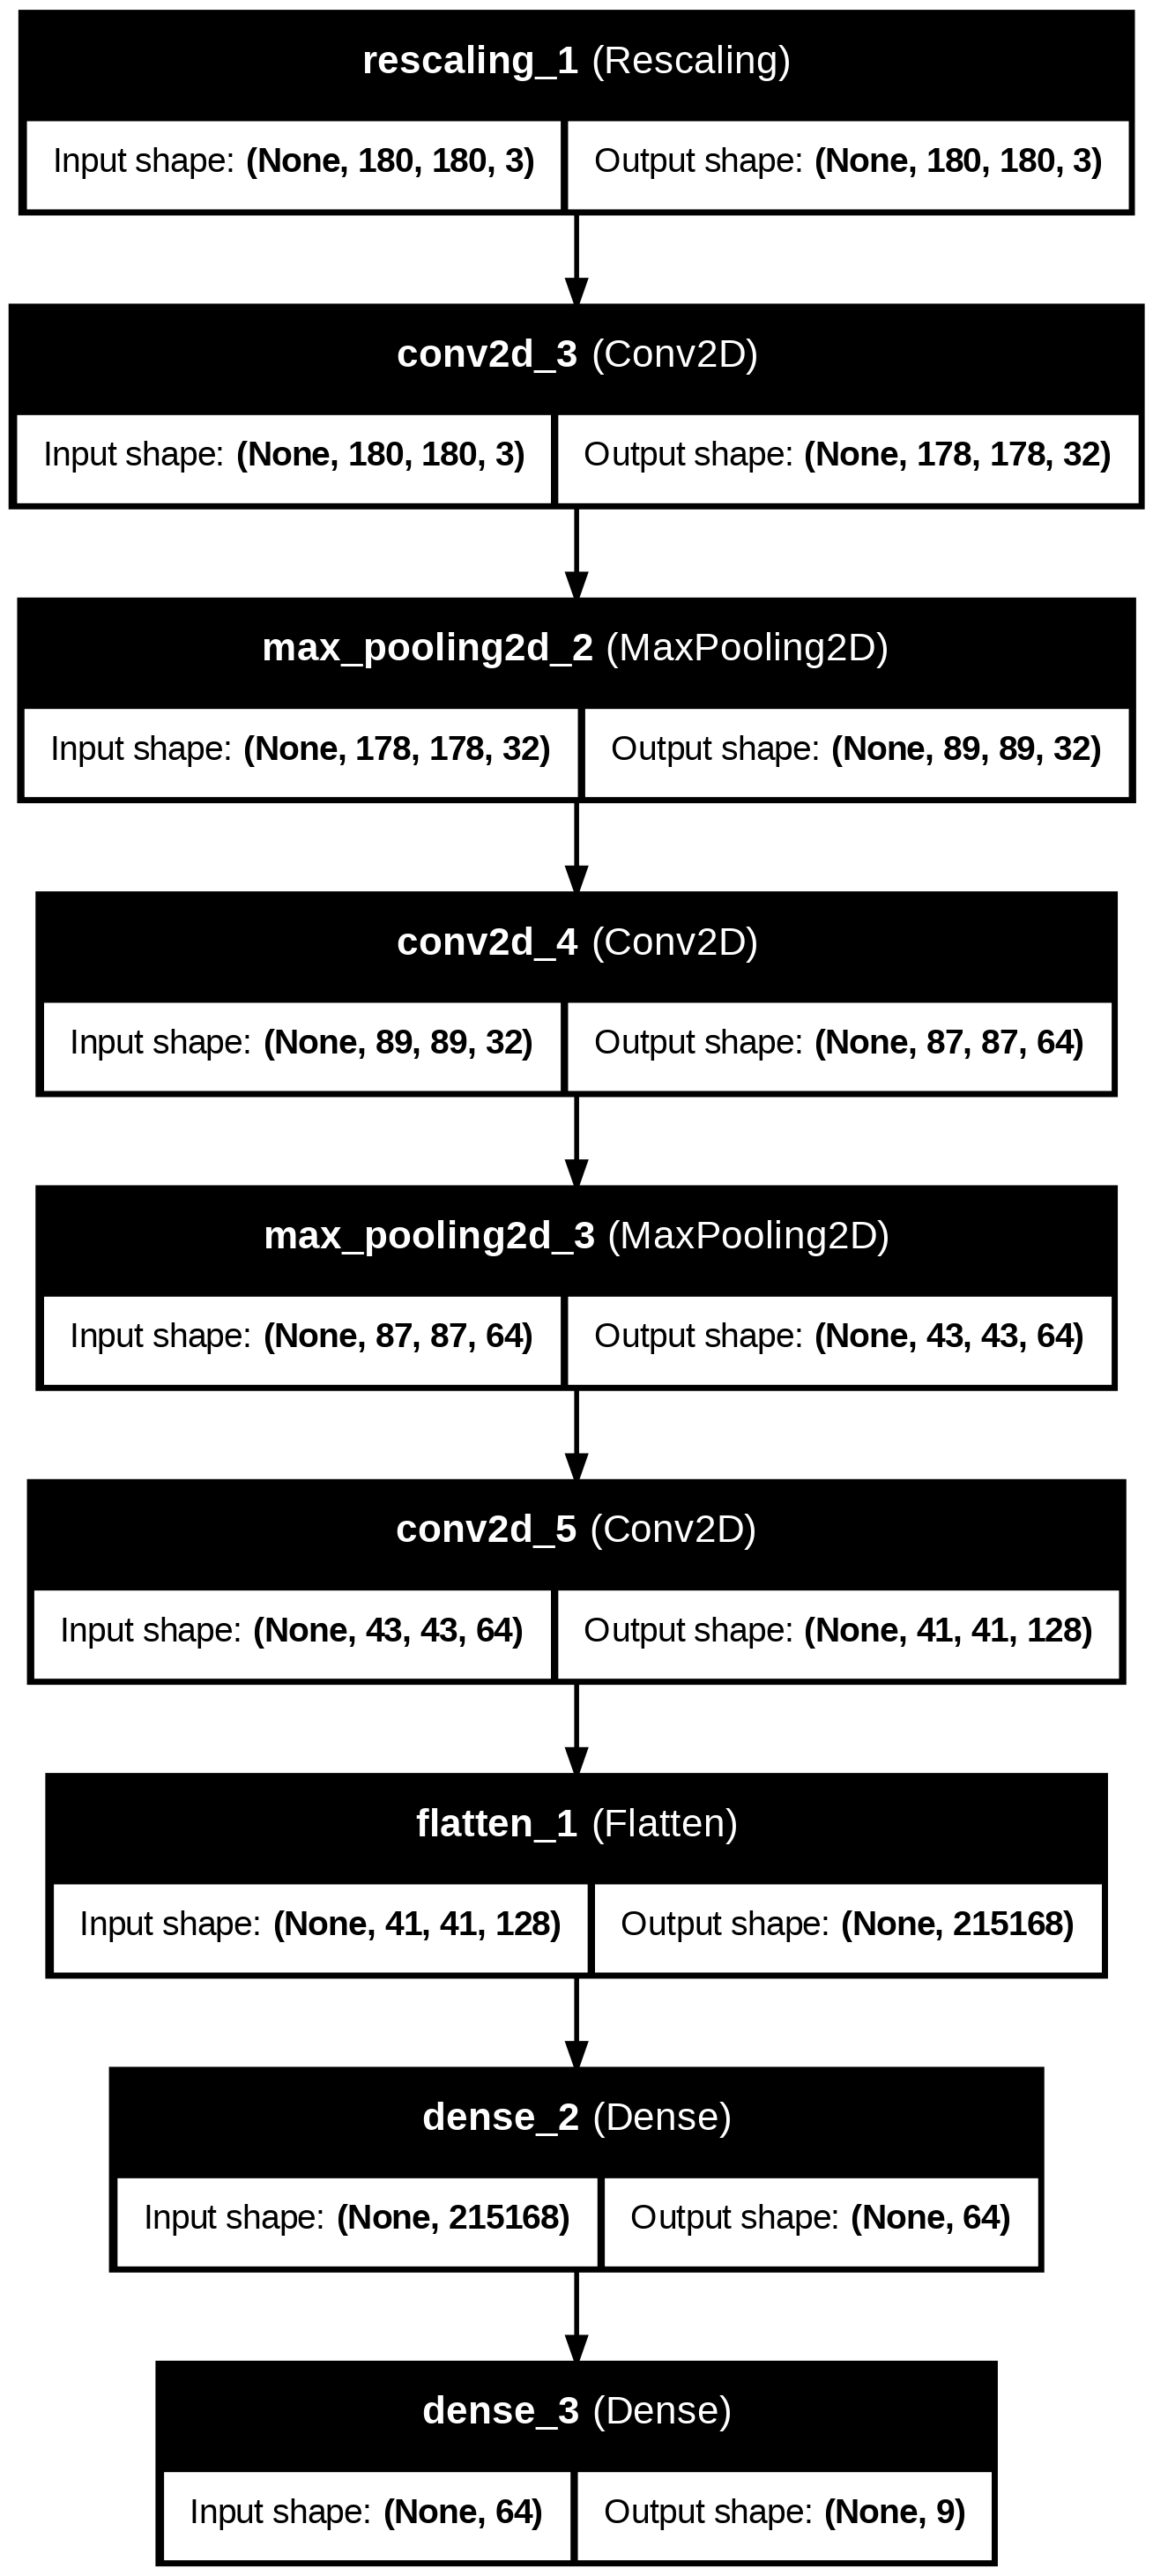

In [66]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [67]:
# Compiling the Model

# The Adam optimizer combines the benefits of momentum and adaptive learning rates for efficient and effective training of deep learning models.
# It uses first and second moment estimates of gradients to adaptively adjust learning rates for each parameter.

model.compile(
    optimizer="Adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
    )

# ModelCheckpoint saves the model during training at specified intervals or when performance improves, ensuring the best model is preserved.
checkpoint = ModelCheckpoint(
    "model.h5.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="auto",verbose=1
    )

# Early stopping is a regularization technique that halts training when the model's performance on a validation set stops improving, preventing overfitting.
# It monitors a specified metric and stops after a patience period if no further improvement is observed.
# This saves computational resources and ensures the model generalizes well.
earlystop = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    mode="auto",
    verbose=1
    )

In [68]:
# Train the model
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[checkpoint,earlystop]
    )

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1986 - loss: 2.7448
Epoch 1: val_accuracy improved from -inf to 0.39130, saving model to model.h5.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 442s 3s/step - accuracy: 0.1991 - loss: 2.7408 - val_accuracy: 0.3913 - val_loss: 1.9314
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4236 - loss: 1.5471
Epoch 2: val_accuracy did not improve from 0.39130
169/169 ━━━━━━━━━━━━━━━━━━━━ 428s 3s/step - accuracy: 0.4236 - loss: 1.5469 - val_accuracy: 0.3043 - val_loss: 2.1313
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4930 - loss: 1.3681
Epoch 3: val_accuracy improved from 0.39130 to 0.52174, saving model to model.h5.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 441s 3s/step - accuracy: 0.4932 - loss: 1.3678 - val_accuracy: 0.5217 - val_loss: 2.0952
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5903 - loss: 1.1269
Epoch 4: val_accuracy improved from 0.52174 to 0.56522, saving model to model.h5.ker

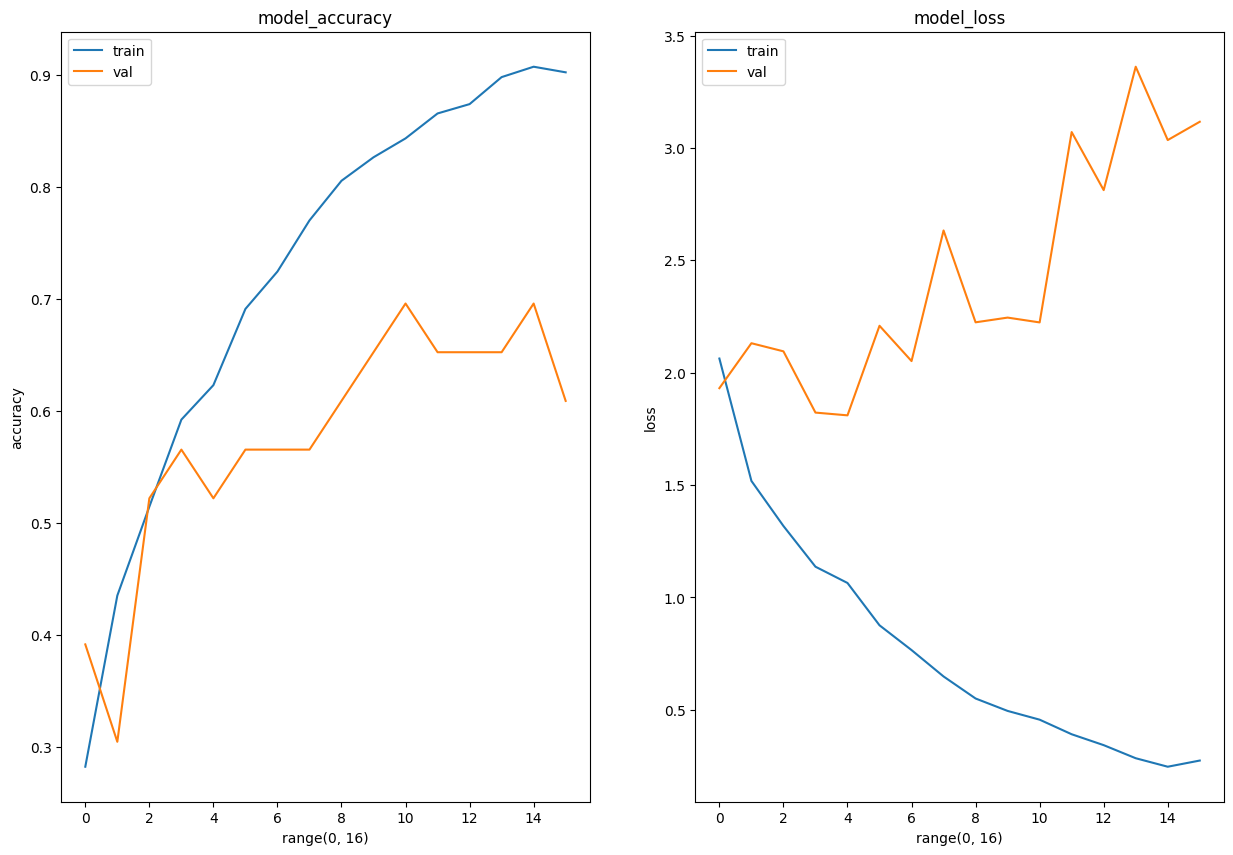

In [69]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()


# Model Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


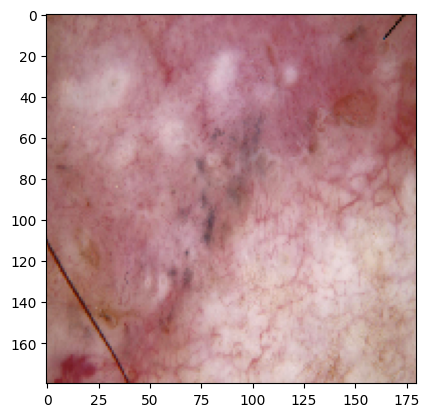

In [70]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-10],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )